<a href="https://colab.research.google.com/github/sakthi-projects-1906/Netflix_SQL_Analysis/blob/main/e_comerce45.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap lime yellowbrick --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import shap
import lime
import lime.lime_tabular
import graphviz

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from yellowbrick.regressor import ResidualsPlot, PredictionError

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 902.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
###load data
import pandas as pd

# Path to your dataset in Colab's temporary storage
file_path = '/content/rural_ecommerce_dataset.csv'  # Default upload location

# Load the dataset
df = pd.read_csv(file_path)

In [38]:

# Show basic info
print("=== Dataset Info ===\n")
print(f"• Rows: {df.shape[0]}")
print(f"• Columns: {df.shape[1]}\n")

# Display first 10 rows with nice formatting
print("=== First 10 Rows ===")
display(df.head(10))  # 'display' works better than print in Colab

# Show column data types
print("\n=== Column Types ===")
print(df.dtypes.to_string())  # to_string() for cleaner output


=== Dataset Info ===

• Rows: 202100
• Columns: 21

=== First 10 Rows ===


,Household_Income,Employment_Rate,Agricultural_Productivity,Tech_Expenditure,Internet_Penetration,Smartphone_Usage,Ecommerce_Awareness,Road_Connectivity,Warehouse_Proximity,Electricity_Availability,...,Literacy_Rate,Gender_Equality_Index,Trust_in_Online_Transactions,Ecommerce_Growth,Average_Order_Value,Repeat_Customer_Rate,Subsidy_Accessibility,Skill_Program_Availability,Policy_Coherence_Score,Trust_Index
0,10000,0.9,100,50,40,10,2,1,10,5,...,30,0.1,2,10,10,0.1,0,1,1,0.169451
1,20000,0.6,200,200,20,50,1,1,20,5,...,30,0.1,1,20,100,0.1,0,1,1,-0.830549
2,10000,0.6,400,200,20,30,1,1,20,5,...,30,0.1,1,10,100,0.1,0,0,0,-0.830549
3,5000,0.4,100,50,40,10,1,2,10,5,...,50,0.1,4,10,50,0.3,1,1,2,2.169451
4,5000,0.8,200,50,20,30,4,1,20,5,...,50,0.1,4,20,50,0.9,0,1,1,2.169451
5,5000,0.4,100,100,80,10,1,2,10,5,...,30,0.5,3,10,10,0.3,0,0,0,1.169559
6,5000,0.8,100,50,60,50,1,1,10,15,...,50,0.1,4,20,50,0.1,0,1,1,2.169451
7,5000,0.8,100,50,20,30,2,2,10,5,...,30,0.1,3,10,10,0.3,0,1,1,1.169451
8,5000,0.6,100,100,20,10,1,3,10,10,...,70,0.1,2,10,100,0.1,1,1,2,0.169451
9,5000,0.6,100,50,60,10,1,3,10,5,...,50,0.1,1,10,10,0.3,0,1,1,-0.830549



=== Column Types ===
Household_Income                  int64
Employment_Rate                 float64
Agricultural_Productivity         int64
Tech_Expenditure                  int64
Internet_Penetration              int64
Smartphone_Usage                  int64
Ecommerce_Awareness               int64
Road_Connectivity                 int64
Warehouse_Proximity               int64
Electricity_Availability          int64
Logistics_Performance             int64
Literacy_Rate                     int64
Gender_Equality_Index           float64
Trust_in_Online_Transactions      int64
Ecommerce_Growth                  int64
Average_Order_Value               int64
Repeat_Customer_Rate            float64
Subsidy_Accessibility             int64
Skill_Program_Availability        int64
Policy_Coherence_Score            int64
Trust_Index                     float64


In [39]:

#Drop constant or irrelevant columns
#df = df.drop(columns=['Priority_Score', 'Priority_Level'])

# Check for missing values
print(df.isnull().sum().sort_values(ascending=False))

df.fillna(df.mean(), inplace=True)

# Define features and target (e.g., predict Ecommerce_Growth)
X = df.drop(columns=['Ecommerce_Growth'])
y = df['Ecommerce_Growth']

Household_Income                0
Employment_Rate                 0
Agricultural_Productivity       0
Tech_Expenditure                0
Internet_Penetration            0
Smartphone_Usage                0
Ecommerce_Awareness             0
Road_Connectivity               0
Warehouse_Proximity             0
Electricity_Availability        0
Logistics_Performance           0
Literacy_Rate                   0
Gender_Equality_Index           0
Trust_in_Online_Transactions    0
Ecommerce_Growth                0
Average_Order_Value             0
Repeat_Customer_Rate            0
Subsidy_Accessibility           0
Skill_Program_Availability      0
Policy_Coherence_Score          0
Trust_Index                     0
dtype: int64



=== Correlation Heatmap ===


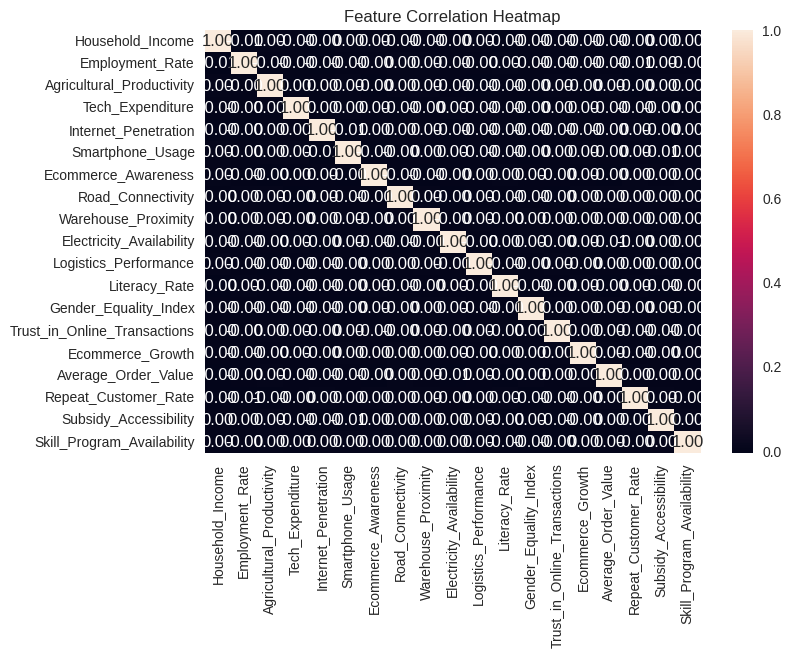

In [11]:
###EDA — Highlighted
print("\n=== Correlation Heatmap ===")
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [40]:

###Feature engineering — Policy Coherence Score and Trust Index
if set(['Skill_Program_Availability', 'Subsidy_Accessibility']).issubset(df.columns):
    df['Policy_Coherence_Score'] = df[['Skill_Program_Availability', 'Subsidy_Accessibility']].sum(axis=1)

trust_features = ['Trust_in_Online_Transactions', 'Gender_Equality_Index']
if set(trust_features).issubset(df.columns):
    pca = PCA(n_components=1)
    df['Trust_Index'] = pca.fit_transform(df[trust_features])

In [41]:

###Scale
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [42]:

##split
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [48]:
##models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_decomposition import PLSRegression

# OLS model
ols = LinearRegression().fit(X_train, y_train)

# CART model
cart = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)

# PLSR model
plsr = PLSRegression(n_components=2).fit(X_train, y_train)


In [49]:
###Gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 5, 10, 15, 20]}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best CART model
best_cart = grid_search.best_estimator_


In [63]:

####valuation function with MAPE and R²
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import time

def evaluate_model(name, model, X_test, y_test):
    start = time.time()
    preds = model.predict(X_test)
    end = time.time()
    return {
        "Model": name,
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "MAE": mean_absolute_error(y_test, preds),
        "MAPE": mean_absolute_percentage_error(y_test, preds) * 100,
        "R2": r2_score(y_test, preds),
        "Inference Time (s)": end - start
    }

results = [
    evaluate_model("OLS", ols, X_test, y_test),
    evaluate_model("CART", best_cart, X_test, y_test),
    evaluate_model("PLSR", plsr, X_test, y_test)
]

pd.DataFrame(results)


,Model,RMSE,MAE,MAPE,R2,Inference Time (s)
0,OLS,13.178727,9.549481,59.670461,-0.000372,0.001070
1,CART,13.179732,9.549236,59.676466,-0.000524,0.001913
2,PLSR,13.178720,9.549475,59.670426,-0.000371,0.002174


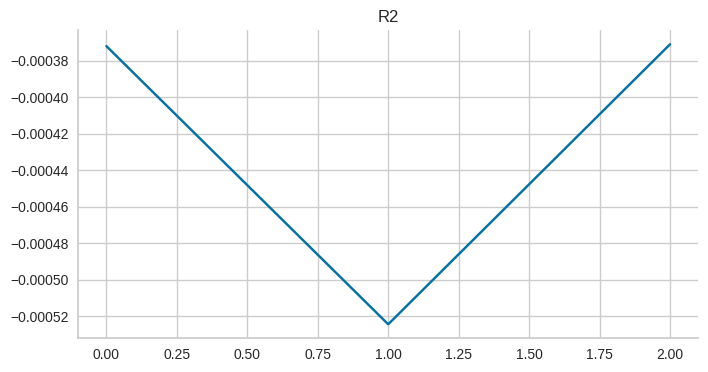

In [64]:
from matplotlib import pyplot as plt
_df_29['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

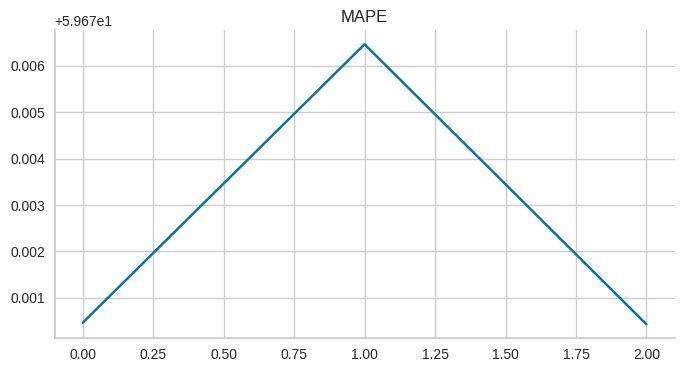

In [61]:
from matplotlib import pyplot as plt
_df_28['MAPE'].plot(kind='line', figsize=(8, 4), title='MAPE')
plt.gca().spines[['top', 'right']].set_visible(False)

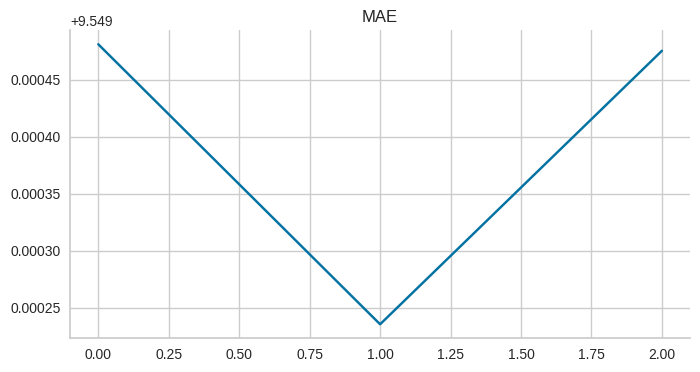

In [60]:
from matplotlib import pyplot as plt
_df_27['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

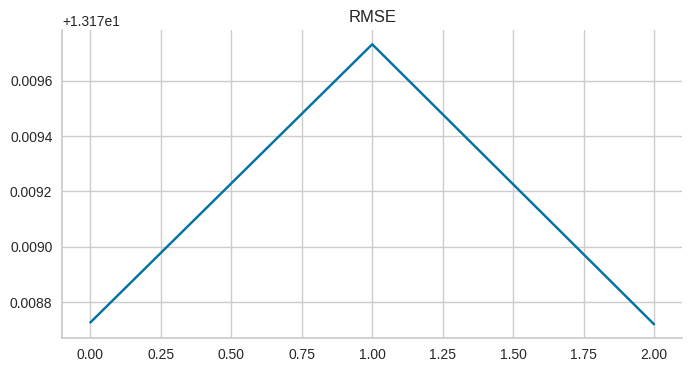

In [59]:
from matplotlib import pyplot as plt
_df_26['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

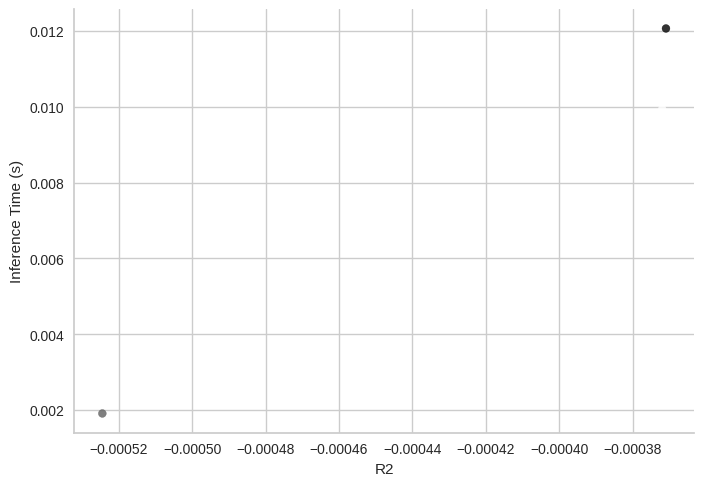

In [58]:
from matplotlib import pyplot as plt
_df_25.plot(kind='scatter', x='R2', y='Inference Time (s)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

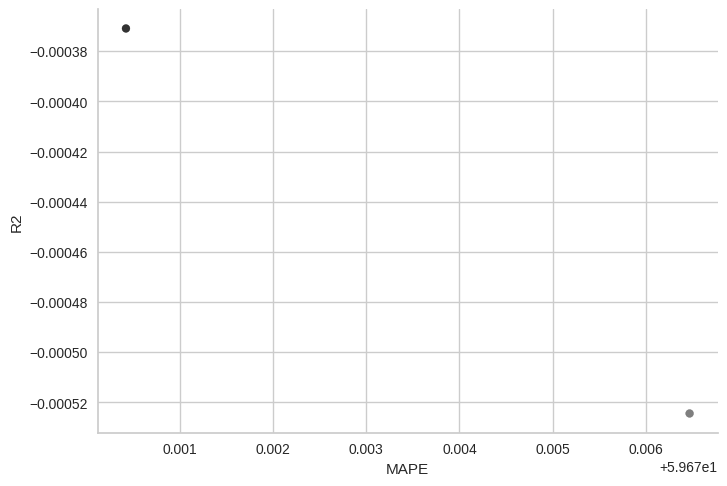

In [57]:
from matplotlib import pyplot as plt
_df_24.plot(kind='scatter', x='MAPE', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

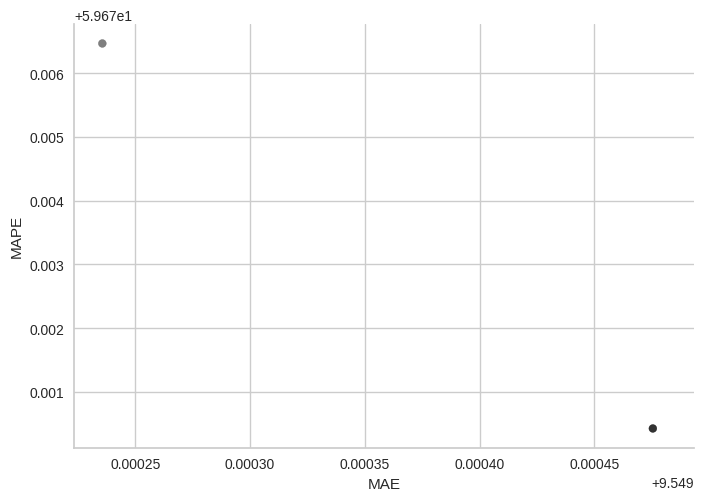

In [56]:
from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='MAE', y='MAPE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

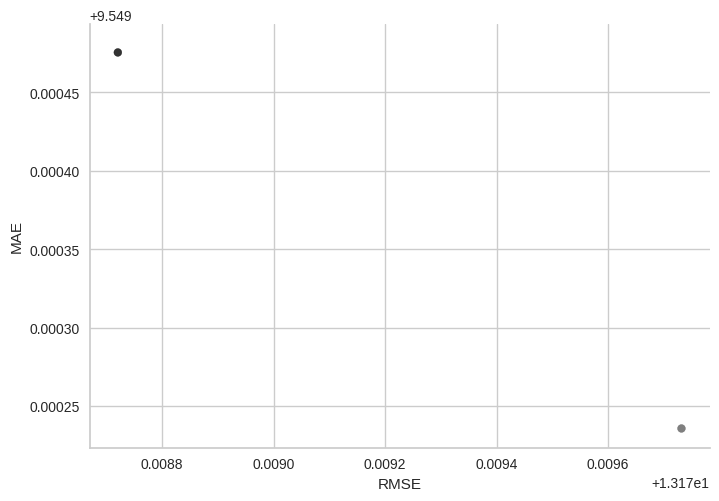

In [55]:
from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='RMSE', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

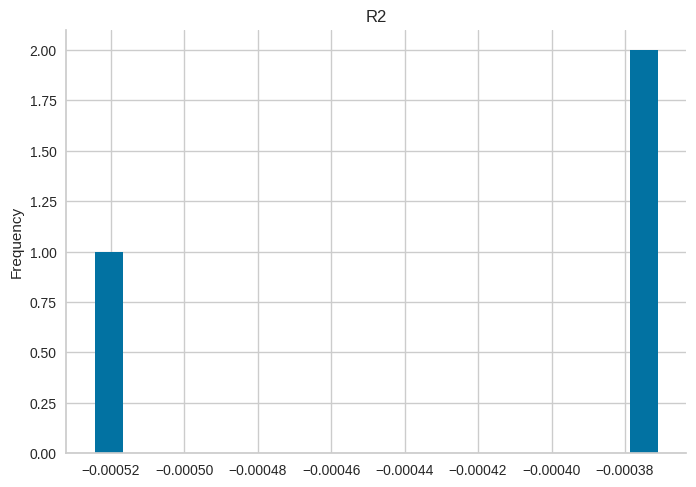

In [54]:
from matplotlib import pyplot as plt
_df_20['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

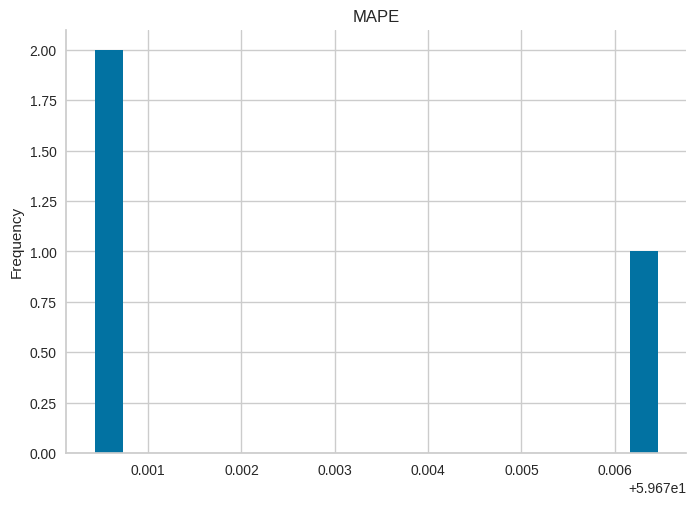

In [53]:
from matplotlib import pyplot as plt
_df_19['MAPE'].plot(kind='hist', bins=20, title='MAPE')
plt.gca().spines[['top', 'right',]].set_visible(False)

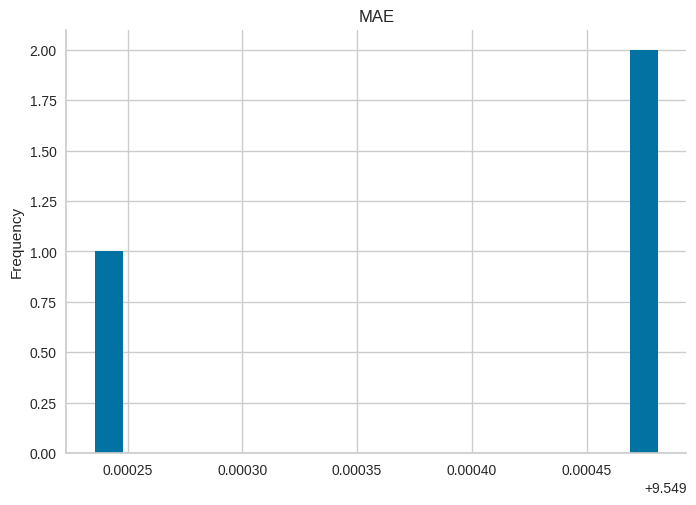

In [52]:
from matplotlib import pyplot as plt
_df_18['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

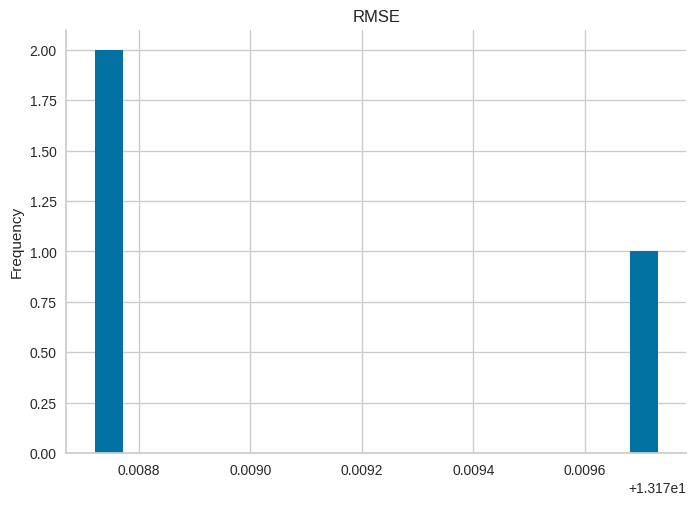

In [51]:
from matplotlib import pyplot as plt
_df_17['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

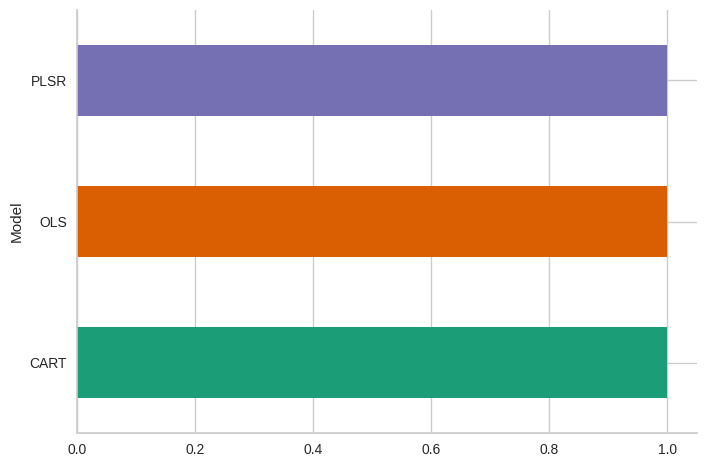

In [50]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_21.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

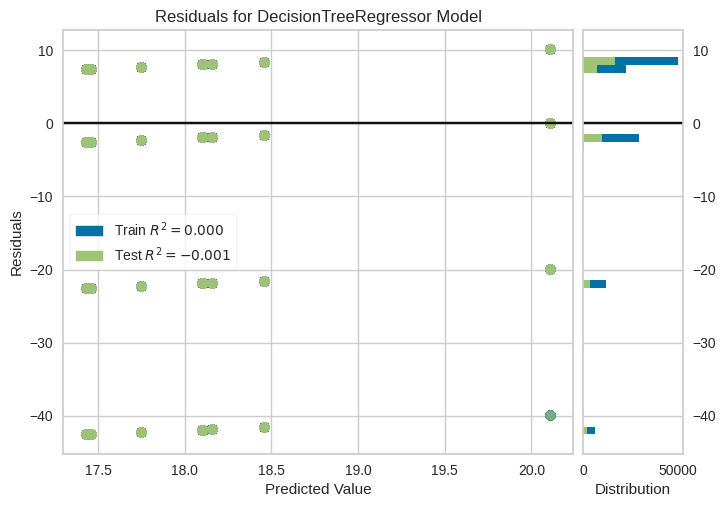

<Axes: title={'center': 'Residuals for DecisionTreeRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [20]:

#### Residual Plot — Yellowbrick
visualizer = ResidualsPlot(best_cart)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

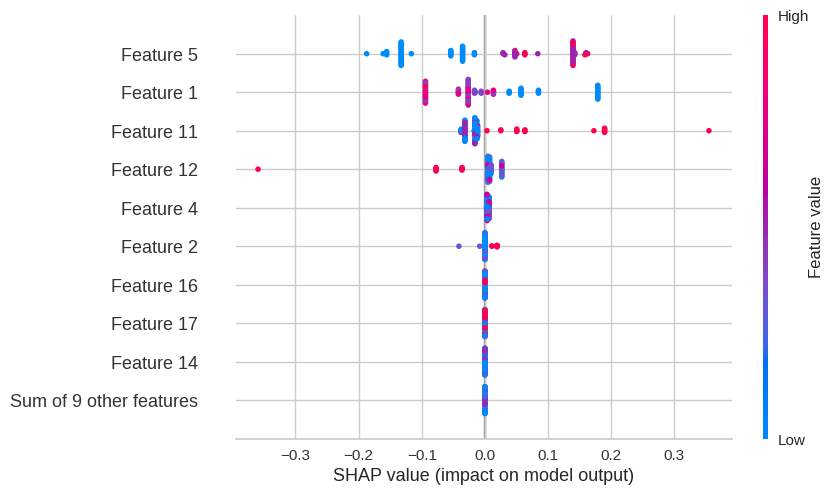

In [22]:

###SHAP
import shap

# Use TreeExplainer for CART
explainer = shap.Explainer(best_cart, X_train)
shap_values = explainer(X_test[:100])

shap.plots.beeswarm(shap_values)


In [24]:

###LIME


import lime
import lime.lime_tabular

# Set mode='regression' since you're using a regression model
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    mode='regression',
    feature_names=df.drop(columns=['Ecommerce_Growth']).columns,
    verbose=True
)

# Explain a single prediction
lime_exp = lime_explainer.explain_instance(
    data_row=X_test[0],
    predict_fn=best_cart.predict
)

lime_exp.show_in_notebook()


Intercept 18.142560714067884
Prediction_local [18.10826427]
Right: 18.10400384540065


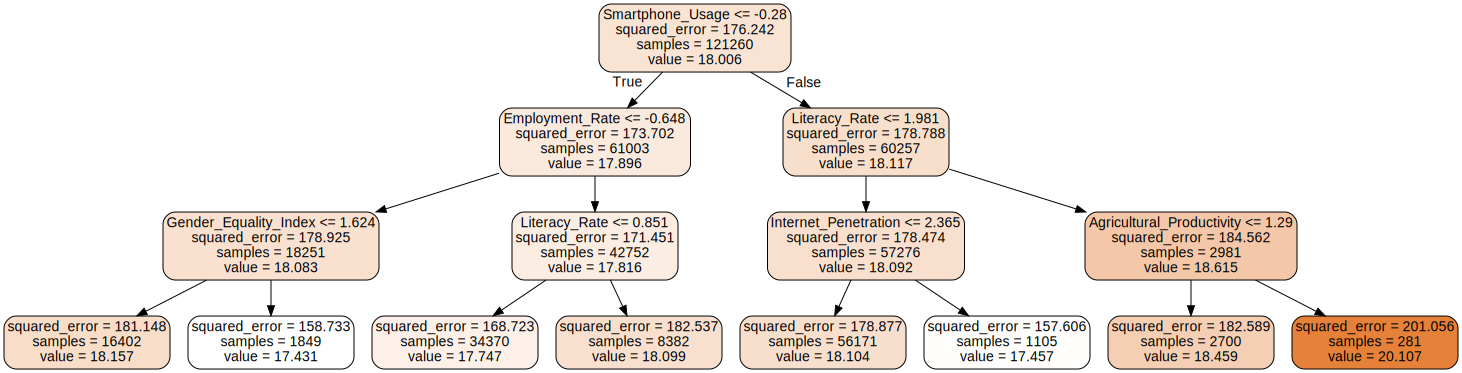

In [27]:
###GRAPHVIZ TREE
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(best_cart, feature_names=X.columns, filled=True, rounded=True)
graphviz.Source(dot_data)

In [28]:

import joblib
joblib.dump(best_cart, 'best_cart_model.pkl')



['best_cart_model.pkl']

In [29]:
import joblib

# Save models
joblib.dump(best_cart, "best_cart_model.pkl")
joblib.dump(ols, "ols_model.pkl")
joblib.dump(plsr, "plsr_model.pkl")



['scaler.pkl']

In [ ]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [30]:

# Save training data for SHAP & LIME
X.columns.to_series().to_csv("feature_names.csv", index=False)
pd.DataFrame(X_train, columns=X.columns).to_csv("X_train.csv", index=False)